In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from scipy.ndimage import gaussian_filter, laplace, convolve, maximum_filter
from PIL import Image
from skimage.feature import peak_local_max
import hyperspy.api as hs
import atomap.api as am
import atomap.dummy_data as dummy_data
from ncempy.io import dm
import os

In [2]:
def SVD(img, k = 10):
    # 对图像矩阵进行SVD分解
    U, singular_values, Vt = np.linalg.svd(img)

    # 设置保留的奇异值数量
    # k = 10  # 这个数字需要根据实际情况调整

    # 构建截断后的Sigma矩阵
    sigma_truncated = singular_values[:k]
    sigma_matrix = np.diag(sigma_truncated)

    # 重建图像
    denoised_image_svd = U[:, :k] @ sigma_matrix @ Vt[:k, :]

    # 将数据转换回uint8以匹配原始图像的类型
    if img.dtype == 'float32' or img.dtype == 'float64':
        denoised_image_svd = (denoised_image_svd * img.ptp()).astype(img.dtype)
    else:
        denoised_image_svd = denoised_image_svd.astype(img.dtype)

    return denoised_image_svd

def blob_detection(img, threshold=150.0, min_distance=10):
    """Detect blobs in the scale-space using a maximum filter."""
    detected_blobs = []
    local_max = maximum_filter(img, min_distance) == img
    blobs = np.argwhere(local_max & (img > threshold))
    for blob in blobs:
        if not any(np.linalg.norm(np.array(blob) - np.array(detected_blob)) < min_distance 
                   for detected_blob in detected_blobs):
            detected_blobs.append((blob[0], blob[1]))
    return detected_blobs

def visualize_results(image, blobs, title, save_path=None) -> Figure:
    """Visualize the original image with detected blobs and return the figure object."""
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')
    for y, x in blobs:
        ax.plot(x, y, 'r+', markersize=2)
    ax.set_title(title)
    ax.axis('off')
    
    if save_path:
        fig.savefig(save_path)
    
    return fig

def gaus_refine(image, input_blobs, plt_title, save_path=None):
    signal_2d = hs.signals.Signal2D(image)
    # signal_2d.plot()
    # s_peaks = am.get_feature_separation(signal_2d, separation_range=(7, 250), show_progressbar=False)
    # s_peaks.plot()
    # print(s_peaks)

    # atom_positions = am.get_atom_positions(signal_2d, separation=10)


    nested_detected_blobs = [[y,x] for x,y in input_blobs]

    # print('atom_positions[0]:', atom_positions[0])
    # print(type(nested_detected_blobs))
    # print('nested_detected_blobs[0]:', nested_detected_blobs[0])

    sublattice = am.Sublattice(nested_detected_blobs, image=signal_2d.data)

    sublattice.find_nearest_neighbors()
    # sublattice.refine_atom_positions_using_center_of_mass(show_progressbar=False)
    sublattice.refine_atom_positions_using_2d_gaussian(show_progressbar=False)
    # sublattice.get_position_history().plot()

    atom_list = sublattice.atom_list
    # print(type(atom_list))

    # print(atom_list[0])
    print(type(atom_list[0]))
    blobs = []

    for pos in atom_list:
        x, y = pos.get_pixel_position()
        blobs.append([y,x])
    
    # save_path = os.path.dirname(image_path) + '/' + 'gaussian_refine.png'
    visualize_results(image, blobs, plt_title, save_path)
    print("blobs_count:", len(blobs))
    return blobs

def read_dm(file_name):
    im = dm.dmReader(file_name)
    data = im['data']
    pixelSize = im['pixelSize']
    return data, pixelSize

def normalizeAndConvert2uint8(image):
    return (((image - image.min())/image.ptp()) * np.iinfo(np.uint8).max).astype(np.uint8) if image.ptp() != 0 else image.astype(np.uint8)

def seperate_into_row(sorted_blob, threshold = 15):
    group = []
    row_count = 0
    i = 0

    # 外层循环
    while i < len(sorted_blob):
        row = [sorted_blob[i]]
        row_count = 1

        # 内层循环检查相邻元素的差值
        for j in range(i + 1, len(sorted_blob)):
            # 如果两个元素的第一个值的差值小于 10，则加入同一组
            if abs(sorted_blob[j][0] - sorted_blob[i][0]) < threshold:
                row.append(sorted_blob[j])
                row_count += 1
            else:
                break  # 如果差值超过 10，结束当前分组

        # 将当前分组加入总列表
        group.append(row)

        # 更新外层循环计数器 i
        i += row_count

    # 输出最终分组
    group_count = len(group)
    print(f"Total groups: {group_count}")
    # for g in group:
    #     print(len(g))
    #     # print(g)
    #     pass
    return group

def seperate_into_column(sorted_blob, threshold = 15):
    group = []
    column_count = 0
    i = 0
    # 外层循环
    while i < len(sorted_blob):
        column = [sorted_blob[i]]
        column_count = 1

        # 内层循环检查相邻元素的差值
        for j in range(i + 1, len(sorted_blob)):
            # 如果两个元素的第二个值的差值小于threshold ，则加入同一组
            if abs(sorted_blob[j][1] - sorted_blob[i][1]) < threshold:
                column.append(sorted_blob[j])
                column_count += 1
            else:
                break  # 如果差值超过 10，结束当前分组

        # 将当前分组加入总列表
        group.append(column)

        # 更新外层循环计数器 i
        i += column_count

    # 输出最终分组
    group_count = len(group)
    print(f"Total groups: {group_count}")
    # for g in group:
    #     print(len(g))
    #     # print(g)
    #     pass
    return group

def sort_blobs_by_y(blobs):
    sort_b = sorted(blobs, key=lambda x: x[0])
    # print(sort_b[0:80])
    return sort_b

def sort_blobs_by_x(blobs):
    sort_b = sorted(blobs, key=lambda x: x[1])
    return sort_b

In [3]:
dm_dir = '/internfs/yuliang/atom_pos/identify/dataset/VOCl_distance'
png_dir = '/internfs/yuliang/atom_pos/identify/dataset/VOCl_distance_png'
os.makedirs(png_dir, exist_ok=True)

dm_files = os.listdir(dm_dir)
for dm_file in dm_files:
    if not dm_file.endswith('.dm4'):
        continue
    image,ps = read_dm(os.path.join(dm_dir,dm_file))
    print(f"dm_file:{dm_file}, ps:{ps}")
    image = normalizeAndConvert2uint8(image)
    savename = os.path.join(png_dir, os.path.splitext(dm_file)[0]+'.png')
    Image.fromarray(image).save(savename)

dm_file:VOCl-100-2.dm4, ps:[0.01626, 0.01626]
dm_file:VOCl-sim-100-0513.dm4, ps:[0.01003333, 0.01003333]
dm_file:VCL2-010-exp-0526.dm4, ps:[0.01626016, 0.01626016]
dm_file:vcl2-exp-0528.dm4, ps:[0.01626016, 0.01626016]
dm_file:VOCl-010-2.dm4, ps:[0.01960784, 0.01960784]
dm_file:VCl2-010-sim-0526.dm4, ps:[0.01016, 0.01016]
dm_file:VOCl-010-exp.dm4, ps:[0.01626, 0.01626]
dm_file:VOCl-010-sim.dm4, ps:[0.01003333, 0.01003333]
dm_file:VOCl-100.dm4, ps:[0.0097561, 0.0097561]
dm_file:VOCl-sim-100.dm4, ps:[0.0100321, 0.0100321]
dm_file:VOCl-110.dm4, ps:[0.012987, 0.012987]
dm_file:VOCl-100-0423.dm4, ps:[0.0097561, 0.0097561]


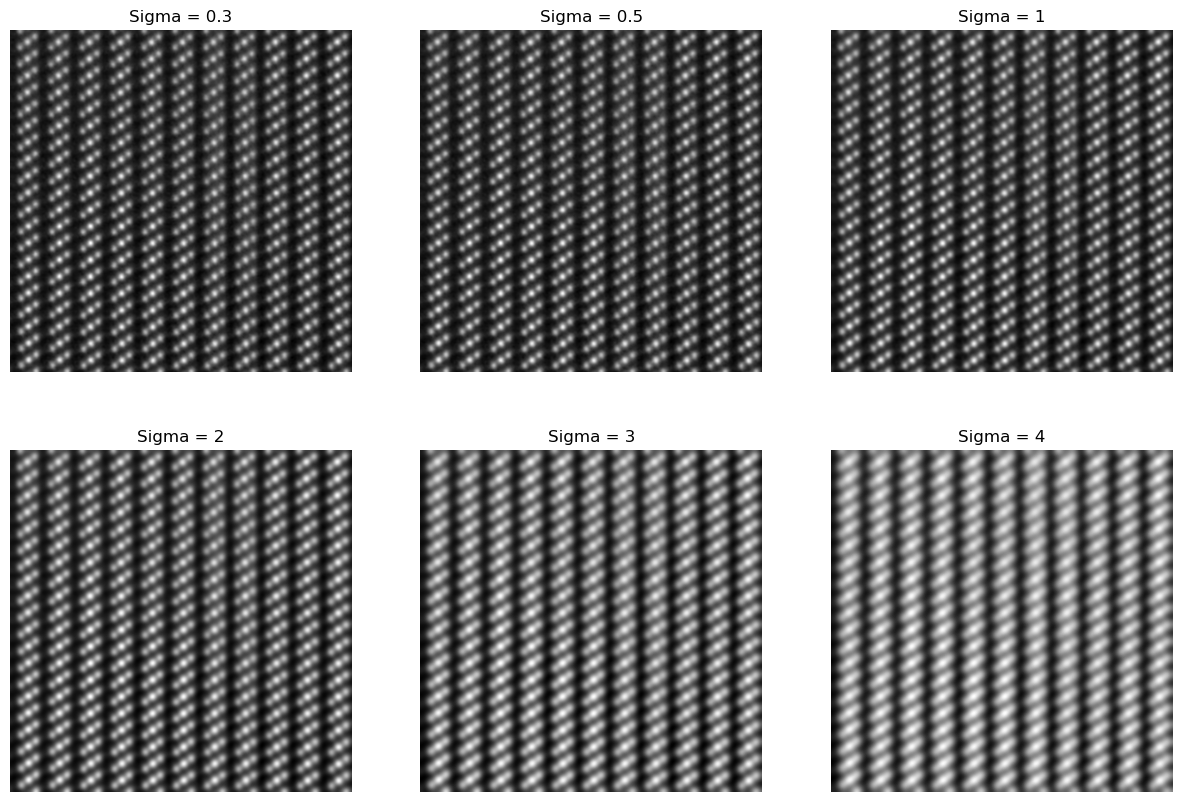

In [4]:
PIXEL_SIZE = 0.01626016
image_path = '/internfs/yuliang/atom_pos/identify/dataset/VOCl_distance_png/exp-0528/vcl2-exp-0528.png'
img = Image.open(image_path).convert('L')
img = np.array(img)


# 尝试不同的 sigma 值
sigmas = [0.3, 0.5, 1, 2, 3, 4]
filtered_images = [gaussian_filter(img, sigma=s) for s in sigmas]

# 显示结果
plt.figure(figsize=(15, 10))
for i, sigma in enumerate(sigmas):
    plt.subplot(2, 3, i+1)
    plt.imshow(filtered_images[i], cmap='gray')
    plt.title(f'Sigma = {sigma}')
    plt.axis('off')
plt.show()

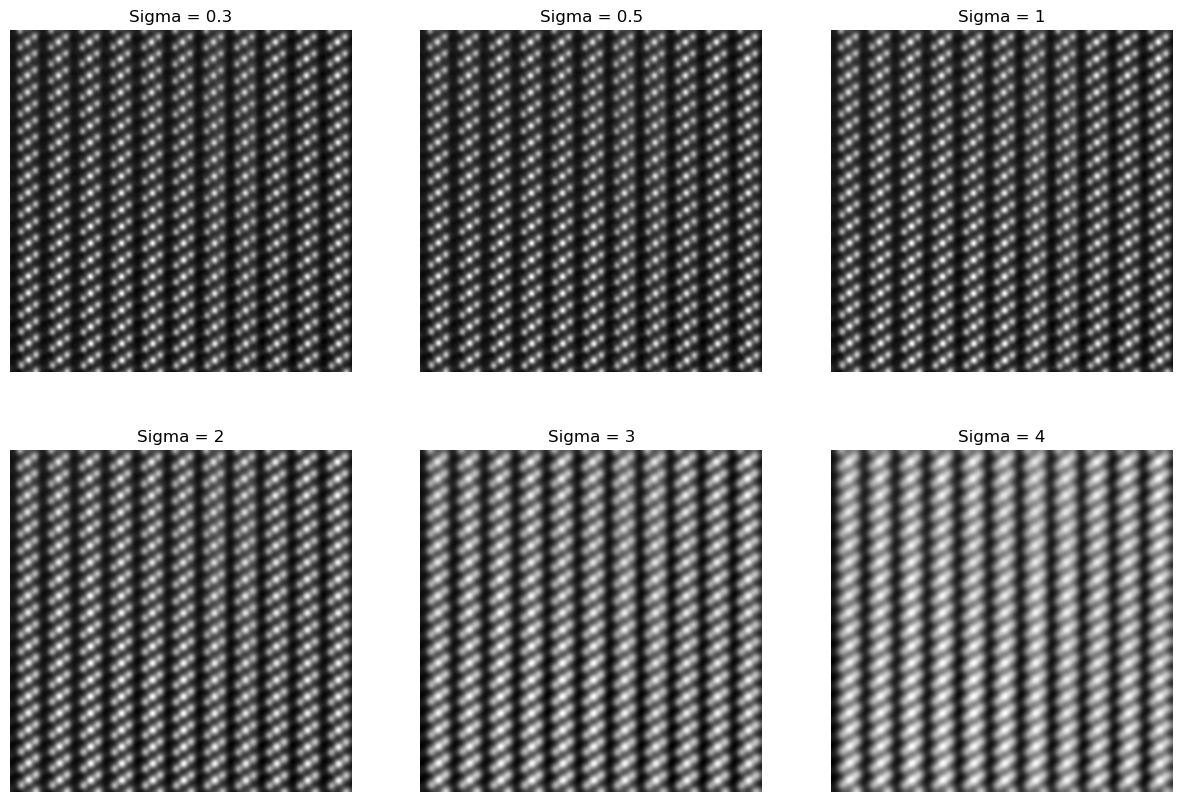

In [5]:
gaus_filt_svd_img = [SVD(img) for img in filtered_images]
# 显示结果
plt.figure(figsize=(15, 10))
for i, sigma in enumerate(sigmas):
    plt.subplot(2, 3, i+1)
    plt.imshow(gaus_filt_svd_img[i], cmap='gray')
    plt.title(f'Sigma = {sigma}')
    plt.axis('off')
plt.show()


blobs_count_g_s: 607
blobs_count_g_s: 600
blobs_count_g_s: 522
blobs_count_g_s: 220
blobs_count_g_s: 0
blobs_count_g_s: 0


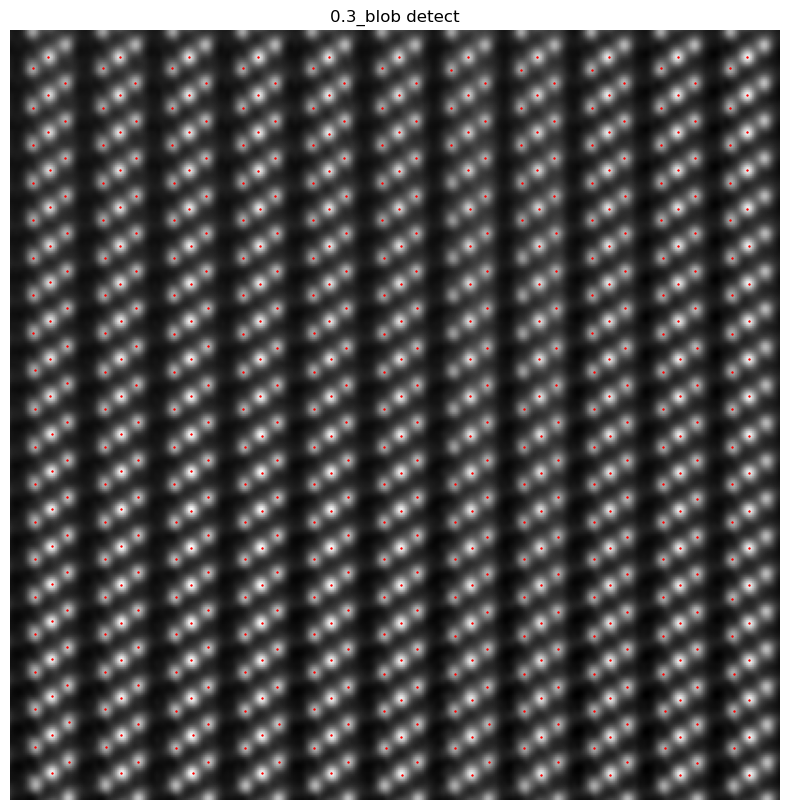

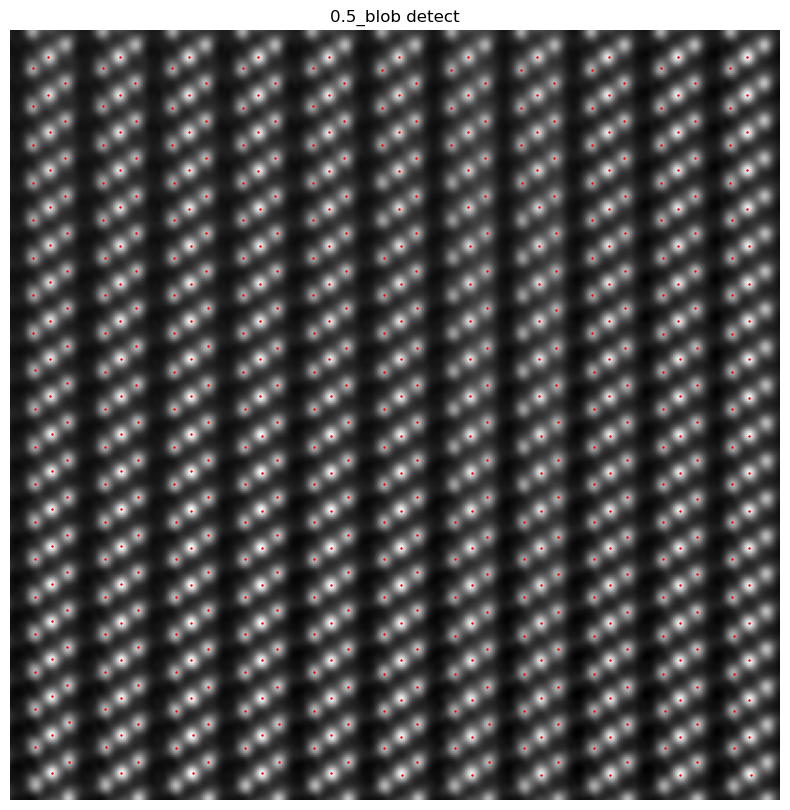

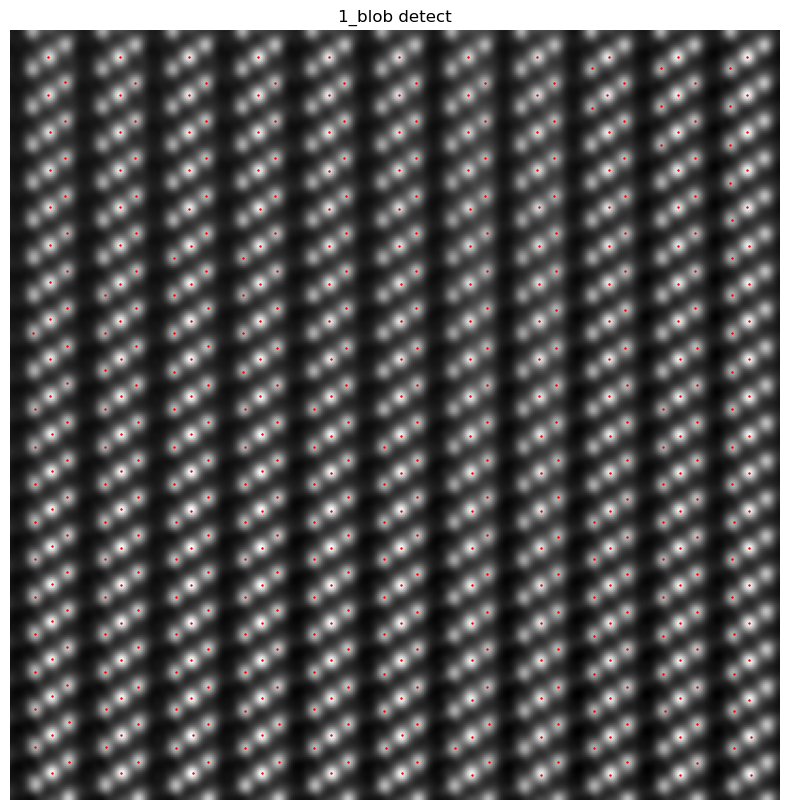

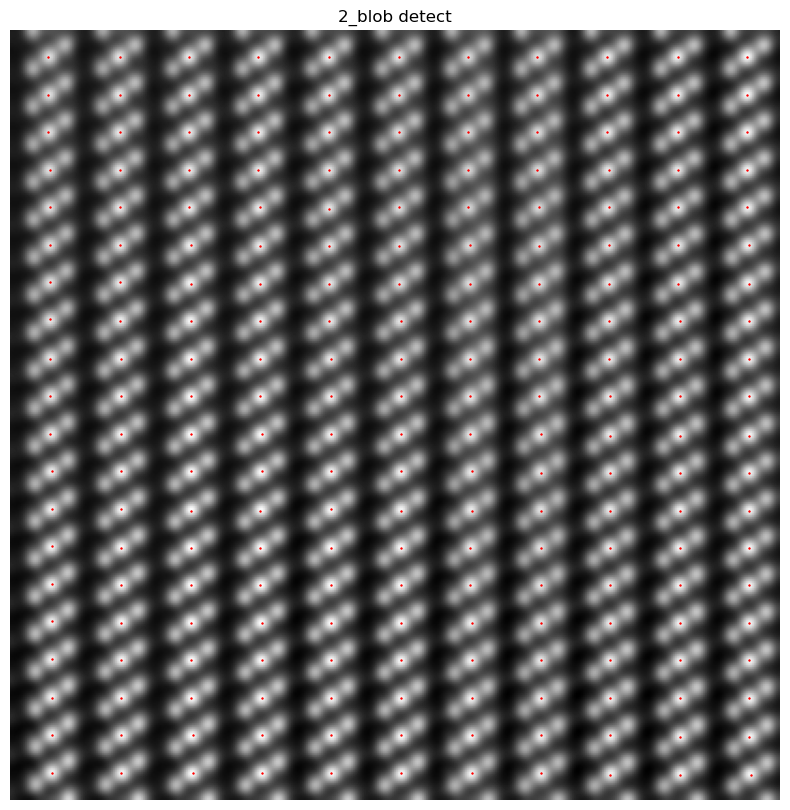

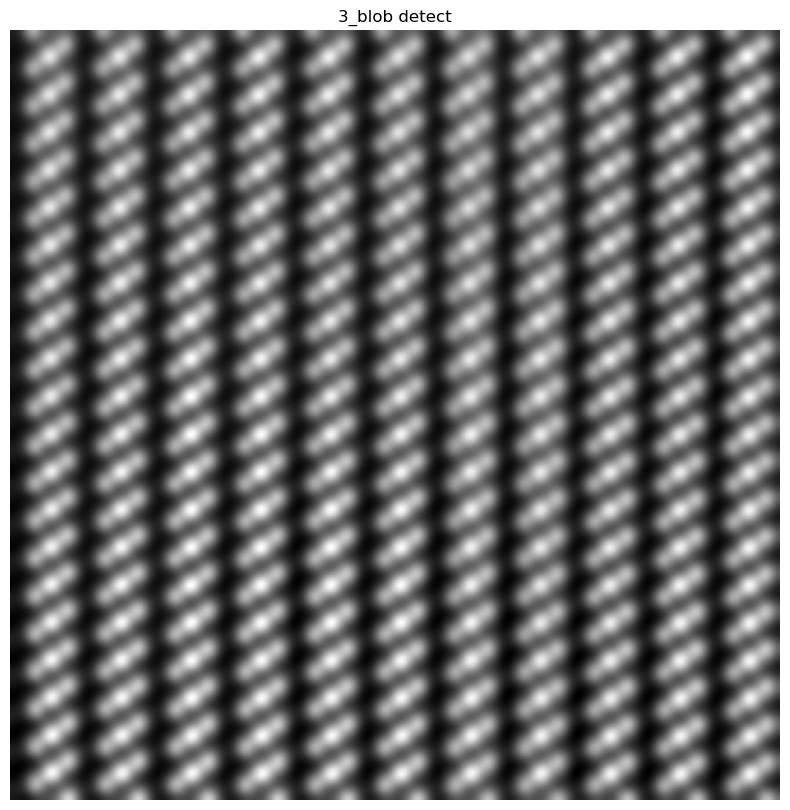

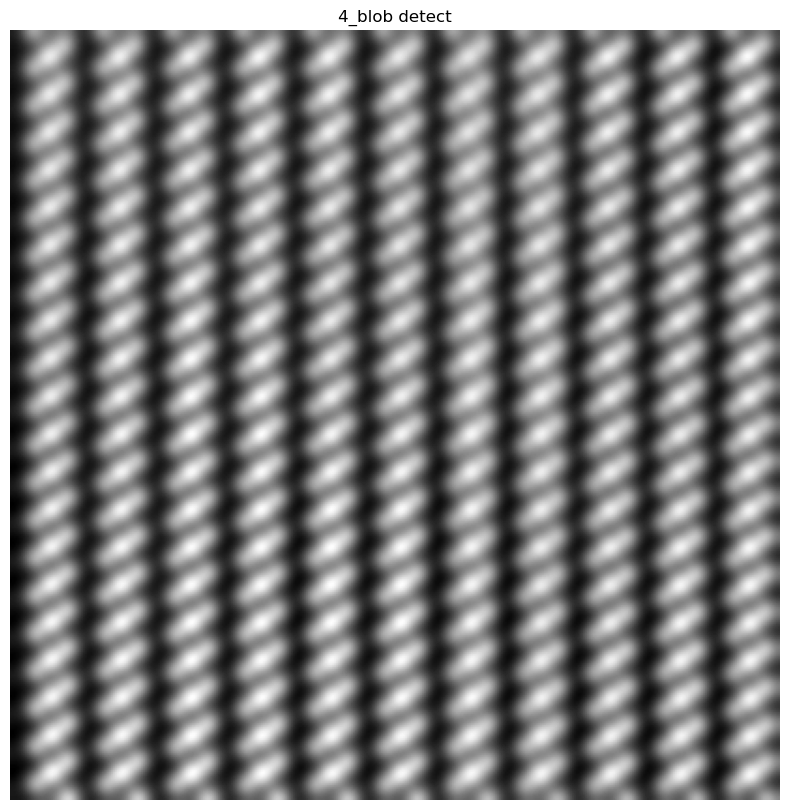

In [6]:
fig_list = []
blob_list = []
threshold = 150
min_distance = 5
edge_threshold = 10
for i, sigma in enumerate(sigmas):
    img = gaus_filt_svd_img[i]
    # height, width = img.shape
    # crop_region = (0, 300, width, height) #左上右下
    # img = img[crop_region[1]:crop_region[3], crop_region[0]:crop_region[2]]
    detected_blobs_g_s = blob_detection(img, threshold=threshold, min_distance=min_distance)
    blob_list.append(detected_blobs_g_s)
    i = 0
    while i < len(detected_blobs_g_s):
        if (detected_blobs_g_s[i][0] < edge_threshold) or (detected_blobs_g_s[i][1] < edge_threshold) or (detected_blobs_g_s[i][0] > (img.shape[0] - edge_threshold)) or (detected_blobs_g_s[i][1] > ((img.shape[1] - edge_threshold))):
            detected_blobs_g_s.remove(detected_blobs_g_s[i])
        else:
            i += 1
    print("blobs_count_g_s:", len(detected_blobs_g_s))
    save_path = os.path.dirname(image_path) + '/' + str(sigma) + '_blob_detect.png'
    fig = visualize_results(img, detected_blobs_g_s, title=str(sigma) + '_blob detect', save_path=None)
    fig_list.append(fig)

<class 'atomap.atom_position.Atom_Position'>
blobs_count: 220


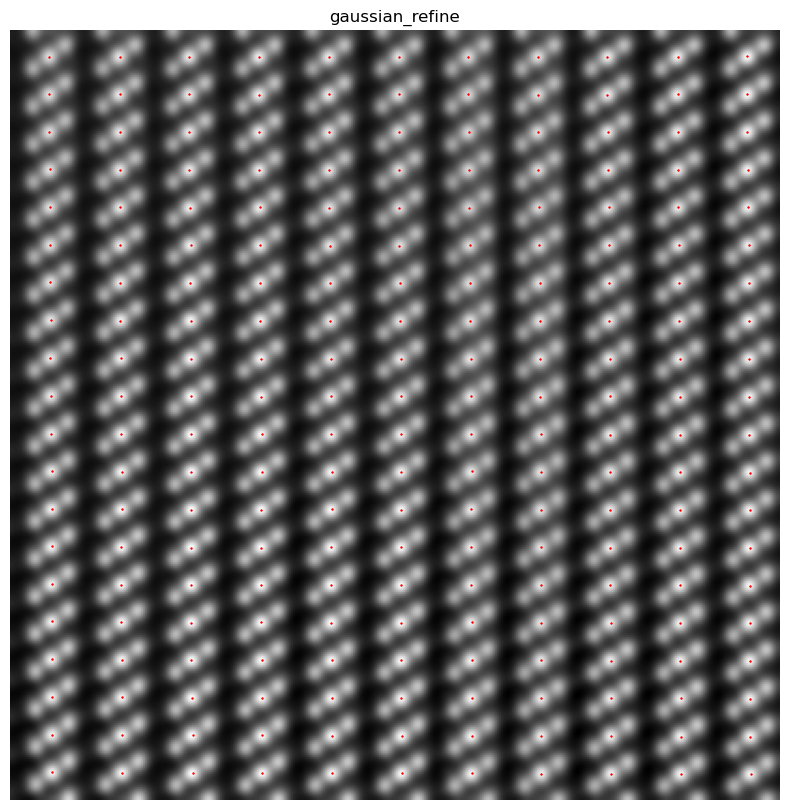

In [7]:
index = 3
sigma = sigmas[index]
input_blobs = blob_list[index]
save_path = os.path.dirname(image_path) + '/' + 'refined.png'
refined_blobs = gaus_refine(image=gaus_filt_svd_img[index], input_blobs=input_blobs, plt_title='gaussian_refine', save_path=save_path)

In [8]:
print('blobs:', refined_blobs)
# 打开文件进行写入
save_path = os.path.dirname(image_path) + '/' + 'blob.txt'
with open(save_path, 'w') as file:
    file.write(f"sigma:{sigma}, threshold:{threshold}, min_distance:{min_distance}, pixel_size:{PIXEL_SIZE}\n")
    for blob in refined_blobs:
        file.write(f"{blob[0]}, {blob[1]}\n")

print("Blobs have been written to blobs.txt")

blobs: [[13.802018802066549, 20.367162397822668], [13.655681944886304, 57.95008759493384], [13.719142385781897, 95.17941870179274], [13.903717953395578, 132.35862598775358], [13.789475957604578, 169.8578362029939], [13.780945216588856, 207.08881961592468], [13.82536165365871, 244.17146233525622], [13.915726758888226, 281.25056490469075], [13.991199349726626, 318.3949056055998], [13.67978564967345, 355.86771551507945], [13.643926236951248, 393.0949690893456], [33.92030325004079, 20.424132549053354], [33.8013066146309, 57.97271010363898], [33.892475361630005, 95.13608635914609], [34.035715215824005, 132.32208563628242], [33.88392315116529, 169.84407725460082], [33.87665593757903, 207.07016593166782], [33.92320875279001, 244.13522061967092], [34.03007890513294, 281.2303314832799], [34.086257379560394, 318.40712825635995], [33.774624203949706, 355.88121433388574], [33.76151806558413, 393.0865898072442], [53.99328772985619, 20.459142587811325], [53.90369151997998, 58.032916349654386], [54.0

# 剔除原子

In [ ]:
remove_list = [0,1,2,3,4,5,7,8,11,14,16]
remove_list.sort(reverse=True)
for index in remove_list:
    refined_blobs.pop(index)

print('blobs:', refined_blobs)
print('blobs_count:', len(refined_blobs))
# 打开文件进行写入
save_path = os.path.dirname(image_path) + '/' + 'blob.txt'
with open(save_path, 'w') as file:
    file.write(f"sigma:{sigma}, threshold:{threshold}, min_distance:{min_distance}\n")
    for blob in refined_blobs:
        # 将每个点转换为字符串并写入文件，每个点占一行
        file.write(f"{blob[0]}, {blob[1]}\n")

print("Blobs have been written to blobs.txt")

[[16.128807585160466, 37.330271426022755], [16.715599006379833, 87.03286907675607], [17.219343416719187, 137.2702124055712], [17.956969377761176, 188.18190255792007], [18.362233274618617, 238.15383615981182], [19.269004271768093, 288.75039061588797], [19.850237613055395, 338.89847600998155], [20.521712963060068, 388.972551749705], [21.704929661006087, 439.3169173396441], [22.77837902591064, 489.48245983378797], [23.52024746947227, 540.4072378407079], [24.64924583433391, 590.8592641106362], [25.798100768315077, 640.940305996113], [26.472384909914748, 691.173207638779], [27.07454127466098, 741.3504403107535], [27.8436992069847, 792.0535713684644], [29.38015657785945, 25.33982393437106], [28.6483132236669, 842.5669698914403], [30.175746768155513, 75.44285578310466], [29.83622709393258, 893.3246992607919], [30.85796353075259, 125.85742809575844], [31.309531777549218, 175.989959428548], [31.934636129703296, 226.21834670443957], [31.08929024822193, 943.908749766109], [31.861109067375228, 994

In [9]:
sorted_refined_blobs = sort_blobs_by_x(refined_blobs)
# print(sorted_refined_blobs)
        
# group = seperate_into_row(sorted_refined_blobs)
group = seperate_into_column(sorted_refined_blobs, threshold=30)

for i, row in enumerate(group):
    group[i] = sorted(row, key=lambda x: x[0])

print(group[0])
print(len(group[0]))

Total groups: 11
[[13.802018802066549, 20.367162397822668], [33.92030325004079, 20.424132549053354], [53.99328772985619, 20.459142587811325], [73.89621927217375, 20.806801003065786], [93.99253322368901, 20.96196307366343], [114.06799557750759, 21.060225399090246], [134.12905174851318, 21.08801354361039], [154.27043631094605, 21.175398250809046], [174.67298680571145, 21.0910311510912], [194.82812282583285, 21.243029172915968], [215.02712344979707, 21.42947996024433], [234.9383177020249, 21.85653447811485], [255.01920968049643, 21.902105355701053], [275.0887476964735, 21.937037231545], [295.09685428853516, 21.930707539567084], [315.1528452740246, 21.96715368042139], [335.17907935593877, 22.00977253253476], [355.45573049732207, 21.840336651509105], [375.59626609918877, 21.978047208998817], [395.7156834118533, 22.035250008544004]]
20


# 计算同列

# 计算同列原子间的斜线距离差值

max: 0.006609298262366279
min: -0.004775646348302946


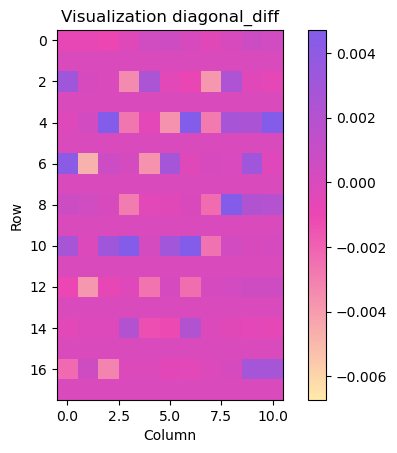

In [10]:
rows = (len(group[0]) - 2)
cols = len(group)
array = []

for i in range(rows):
    row = []
    for j in range(cols):
        row.append(0.0)
    array.append(row)
array = np.array(array)

for i in range(cols):
    for j in range(0, rows, 2):
        d1 = np.sqrt((group[i][j+1][1] - group[i][j][1])**2 + (group[i][j+1][0] - group[i][j][0])**2)
        d2 = np.sqrt((group[i][j+2][1] - group[i][j+1][1])**2 + (group[i][j+2][0] - group[i][j+1][0])**2)
        diff = (d2 - d1)
        diff *= PIXEL_SIZE
        array[j][i] = diff
        # print(f"diff:{diff}")

print("max:", np.max(array))
print("min:", np.min(array))
        
from matplotlib.colors import LinearSegmentedColormap

# 定义颜色：粉色 → 深蓝色 → 橘色
custom_cmap = LinearSegmentedColormap.from_list(
    "pink_orange",
    ["#FFEAAA", "#EC46B3", "#835DEA"]
)
plt.imshow(array, cmap=custom_cmap, interpolation='nearest', vmax = 0.004702550504598062, vmin = -0.006724209540788841)

# 添加颜色条
plt.colorbar()

# 设置坐标轴
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Visualization diagonal_diff')

save_path = os.path.dirname(image_path) + "/" + "diagonal_diff.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)

# 计算同列原子斜线间距

max: 0.3327515138583274
min: 0.3231011636468122


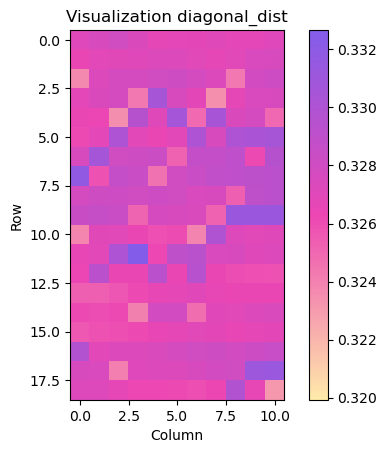

In [11]:
rows = (len(group[0]) - 1)
cols = len(group)
array = []

for i in range(rows):
    row = []
    for j in range(cols):
        row.append(0.0)
    array.append(row)
array = np.array(array)

for i in range(cols):
    for j in range(0, rows, 1):
        dist = np.sqrt((group[i][j+1][1] - group[i][j][1])**2 + (group[i][j+1][0] - group[i][j][0])**2)
        # dist = group[i][j+1][0] - group[i][j][0]
        dist *= PIXEL_SIZE
        array[j][i] = dist
        # print(f"dist:{dist}")
        # if i == 0:
        #     print(f"dist:{dist}")
        
print("max:", np.max(array))
print("min:", np.min(array))

from matplotlib.colors import LinearSegmentedColormap

# 定义颜色：粉色 → 深蓝色 → 橘色
custom_cmap = LinearSegmentedColormap.from_list(
    "pink_orange",
    ["#FFEAAA", "#EC46B3", "#835DEA"]
)
plt.imshow(array, cmap=custom_cmap, interpolation='nearest', vmax = 0.33266355330370095, vmin = 0.31992859119468375)

# 添加颜色条
plt.colorbar()

# 设置坐标轴
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Visualization diagonal_dist')

save_path = os.path.dirname(image_path) + "/" + "diagonal_dist.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)

# 计算垂直原子间距

max: 0.3326522255657176
min: 0.3230405729348166


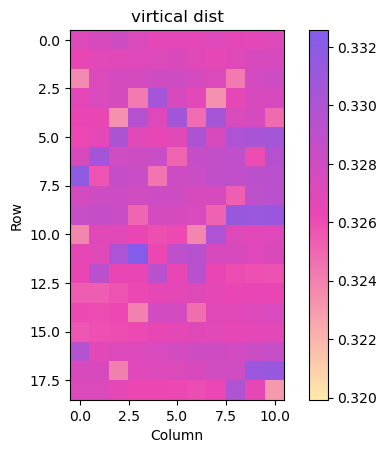

In [12]:
rows = (len(group[1]) - 1)
cols = len(group)
array = []

for i in range(rows):
    row = []
    for j in range(cols):
        row.append(0.0)
    array.append(row)
array = np.array(array)


for i in range(0, len(group)):
    index = 0
    for j in range(0, len(group[i]) - 1):
        d = abs(group[i][j][0] - group[i][j+1][0]) * PIXEL_SIZE
        array[index][i] = d
        index += 1

reduced_rows = array[:-1]
# reduced_rows = [row[1:] for row in reduced_rows]
# reduced_rows = [row[:-1] for row in reduced_rows]
# 使用matplotlib的imshow函数来可视化数组
print("max:", np.max(array))
print("min:", np.min(array))
from matplotlib.colors import LinearSegmentedColormap

# 定义颜色：粉色 → 深蓝色 → 橘色
custom_cmap = LinearSegmentedColormap.from_list(
    "pink_orange",
    ["#FFEAAA", "#EC46B3", "#835DEA"]
)
plt.imshow(array, cmap=custom_cmap, interpolation='nearest', vmax = 0.33257694535904103, vmin = 0.31992852769856434)

# 添加颜色条
plt.colorbar()

# 设置坐标轴
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('virtical dist')

save_path = os.path.dirname(image_path) + "/" + "vertical_dist.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)

# 计算垂直原子间距差值

max: 0.008231803298508093
min: -0.00700949821630577


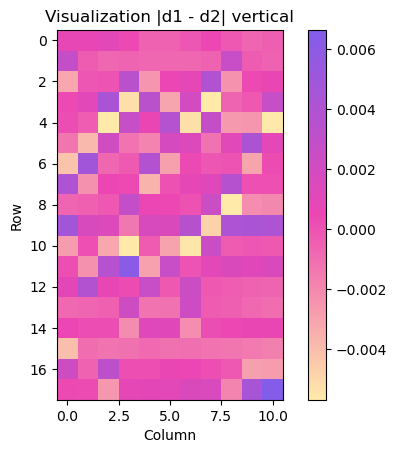

In [13]:
rows = (len(group[1]) - 2) 
cols = len(group)
array = []

for i in range(rows):
    row = []
    for j in range(cols):
        row.append(0.0)
    array.append(row)
array = np.array(array)


for i in range(0, len(group)):
    index = 0
    for j in range(0, len(group[i]) - 2):
        d1 = abs(group[i][j][0] - group[i][j+1][0])
        d2 = abs(group[i][j+1][0] - group[i][j+2][0])
        diff = (d1 - d2) * PIXEL_SIZE
        array[index][i] = diff
        index += 1

reduced_rows = array[:-1]
# reduced_rows = [row[1:] for row in reduced_rows]
# reduced_rows = [row[:-1] for row in reduced_rows]
# 使用matplotlib的imshow函数来可视化数组
print("max:", np.max(array))
print("min:", np.min(array))
from matplotlib.colors import LinearSegmentedColormap

# 定义颜色：粉色 → 深蓝色 → 橘色
custom_cmap = LinearSegmentedColormap.from_list(
    "pink_orange",
    ["#FFEAAA", "#EC46B3", "#835DEA"]
)
plt.imshow(array, cmap=custom_cmap, interpolation='nearest', vmax = 0.006642108842325567, vmin = -0.005681359343335919)

# 添加颜色条
plt.colorbar()

# 设置坐标轴
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Visualization |d1 - d2| vertical')

save_path = os.path.dirname(image_path) + "/" + "vertical_diff.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)

# 计算水平原子间距

rows:81, cols:9
(81, 9)


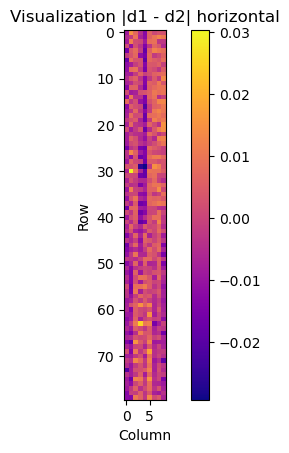

In [29]:
rows = (len(group[1]))
cols = (len(group) - 1) // 2
array = []
print(f'rows:{rows}, cols:{cols}')

for i in range(rows):
    row = []
    for j in range(cols):
        row.append(0.0)
    array.append(row)
array = np.array(array)
print(array.shape)

for i in range(0, len(group) -2, 2):
    index = 0
    for atom1, atom2, atom3 in zip(group[i], group[i+1], group[i+2]):
        d1 = abs(atom1[1] - atom2[1])
        d2 = abs(atom2[1] - atom3[1])
        diff = (d1 - d2) * PIXEL_SIZE
        # print(f'index: {index}')
        array[index][i//2] = diff
        index += 1

reduced_rows = array[:-1]
# reduced_rows = [row[1:] for row in reduced_rows]
# reduced_rows = [row[:-1] for row in reduced_rows]
# 使用matplotlib的imshow函数来可视化数组
plt.imshow(reduced_rows, cmap='plasma', interpolation='nearest')

# 添加颜色条
plt.colorbar()

# 设置坐标轴
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Visualization |d1 - d2| horizontal')

save_path = os.path.dirname(image_path) + "/" + "horizontal_diff.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)

# Read from xyz

{'element': 'V', 'x': -8.325261, 'y': 30.101408, 'z': -7.202433}
{'element': 'V', 'x': -8.325261, 'y': 30.101408, 'z': 0.924153}
{'element': 'V', 'x': -8.325261, 'y': 30.101408, 'z': 9.05074}
{'element': 'V', 'x': -8.325261, 'y': 30.101408, 'z': 17.177326}
{'element': 'V', 'x': -8.325261, 'y': 30.101408, 'z': 25.303913}
{'element': 'V', 'x': -8.325261, 'y': 30.101408, 'z': 33.430499}
{'element': 'V', 'x': -6.660209, 'y': 31.982746, 'z': -9.05074}
{'element': 'V', 'x': -6.660209, 'y': 31.982746, 'z': -0.924153}
{'element': 'V', 'x': -6.660209, 'y': 31.982746, 'z': 7.202433}
{'element': 'V', 'x': -6.660209, 'y': 31.982746, 'z': 15.32902}
{'element': 'V', 'x': -6.660209, 'y': 31.982746, 'z': 23.455607}
{'element': 'V', 'x': -6.660209, 'y': 31.982746, 'z': 31.582193}
{'element': 'V', 'x': -8.325261, 'y': 26.338732, 'z': -7.202433}
{'element': 'V', 'x': -8.325261, 'y': 26.338732, 'z': 0.924153}
{'element': 'V', 'x': -8.325261, 'y': 26.338732, 'z': 9.05074}
{'element': 'V', 'x': -8.325261, '

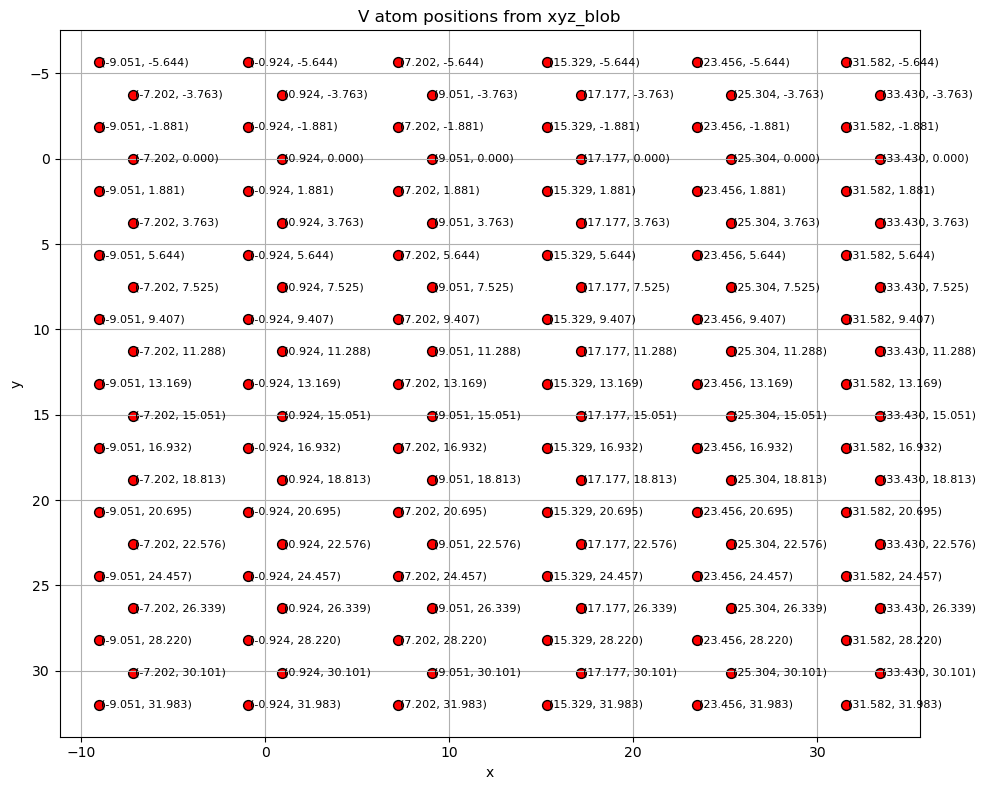

[[31.982746, -9.05074], [28.22007, -9.05074], [20.694718, -9.05074], [24.457394, -9.05074], [-5.644014, -9.05074], [-1.881338, -9.05074], [1.881338, -9.05074], [5.644014, -9.05074], [9.40669, -9.05074], [13.169366, -9.05074], [16.932042, -9.05074], [30.101408, -7.202433], [26.338732, -7.202433], [18.81338, -7.202433], [22.576056, -7.202433], [-3.762676, -7.202433], [0.0, -7.202433], [3.762676, -7.202433], [7.525352, -7.202433], [11.288028, -7.202433], [15.050704, -7.202433], [31.982746, -0.924153], [28.22007, -0.924153], [20.694718, -0.924153], [24.457394, -0.924153], [16.932042, -0.924153], [-5.644014, -0.924153], [-1.881338, -0.924153], [1.881338, -0.924153], [5.644014, -0.924153], [9.40669, -0.924153], [13.169366, -0.924153], [30.101408, 0.924153], [26.338732, 0.924153], [18.81338, 0.924153], [22.576056, 0.924153], [-3.762676, 0.924153], [0.0, 0.924153], [3.762676, 0.924153], [7.525352, 0.924153], [11.288028, 0.924153], [15.050704, 0.924153], [31.982746, 7.202433], [28.22007, 7.2024

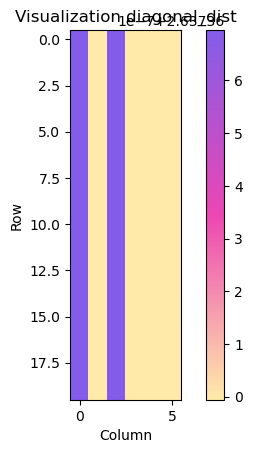

In [77]:
def read_xyz(filename):
    atoms = []
    with open(filename, 'r') as f:
        num_atoms = int(f.readline().strip())  # 第一行是原子数
        _ = f.readline()  # 第二行通常是注释，可以忽略
        for line in f:
            parts = line.strip().split()
            if len(parts) == 4:
                symbol, x, y, z = parts
                atoms.append({
                    'element': symbol,
                    'x': float(x),
                    'y': float(y),
                    'z': float(z)
                })
    return atoms

xyz_blob = []
xyz_data = read_xyz('/internfs/yuliang/torch/identify/dataset/VOCl_distance/xyz/VClO-0513.xyz')
seen_xy = set()

for atom in xyz_data:
    if atom['element'] == 'V':
        xy = (atom['z'], atom['y'])
        if xy not in seen_xy:
            seen_xy.add(xy)
            print(atom)
            xyz_blob.append([atom['y'], atom['z']])  # 注意：y,x顺序为图像坐标


# 绘制 xyz_blob 中的散点图
plt.figure(figsize=(10, 8))
ys = [pt[0] for pt in xyz_blob]
xs = [pt[1] for pt in xyz_blob]

plt.scatter(xs, ys, c='red', s=50, edgecolors='black')  # s 控制点大小

# 添加坐标文本
for x, y in zip(xs, ys):
    plt.text(x + 0.1, y, f'({x:.3f}, {y:.3f})', fontsize=8, ha='left', va='center')

plt.gca().invert_yaxis()  # 常用于图像坐标系统中y轴向下
plt.xlabel('x')
plt.ylabel('y')
plt.title('V atom positions from xyz_blob')
plt.grid(True)
plt.tight_layout()
plt.show()

sorted_refined_blobs = sort_blobs_by_x(xyz_blob)
print(sorted_refined_blobs)
        
# group = seperate_into_row(sorted_refined_blobs)
group = seperate_into_column(sorted_refined_blobs, threshold=3)

for i, row in enumerate(group):
    group[i] = sorted(row, key=lambda x: x[0])

# print(group[0])
# print(len(group[0]))

rows = (len(group[0]) - 1)
cols = len(group)
array = []

for i in range(rows):
    row = []
    for j in range(cols):
        row.append(0.0)
    array.append(row)
array = np.array(array)

for i in range(cols):
    for j in range(0, rows, 1):
        dist = np.sqrt((group[i][j+1][1] - group[i][j][1])**2 + (group[i][j+1][0] - group[i][j][0])**2)
        # dist = np.abs(group[i][j+1][0] - group[i][j][0])
        # dist *= PIXEL_SIZE
        # print(f"index: {j}, {i}")
        array[j][i] = dist
        # array[j][i] = round(dist, 6)  # 保留4位小数，可调整
        # print(f"dist:{dist}")
        if i == 0:
            print(f"dist:{dist}")

from matplotlib.colors import LinearSegmentedColormap

# 定义颜色：粉色 → 深蓝色 → 橘色
custom_cmap = LinearSegmentedColormap.from_list(
    "pink_orange",
    ["#FFEAAA", "#EC46B3", "#835DEA"]
)
plt.imshow(array, cmap=custom_cmap, interpolation='nearest')

# 添加颜色条
plt.colorbar()

# 设置坐标轴
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Visualization diagonal_dist')

save_path = os.path.dirname(image_path) + "/" + "diagonal_dist.png"
plt.savefig(save_path, bbox_inches='tight', dpi=300)